In [21]:
# upgrading sklearn
!pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1556 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/dist

In [22]:
# Importing libraries

#For Dataset Handling
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import itertools

#For model building
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#For Metrics evaluation 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


# 2 Data Analysis

In [27]:
path = '/Users/dishadhake/Desktop/Vehicle insurance claim dataset.csv'

df = pd.read_csv(path)

In [29]:
df.isna().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

you can see there is not any missing values in the dataset

In [30]:
#dropping unnecessary column 
df=df.drop('policy_id', axis=1)

In [35]:
%matplotlib inline

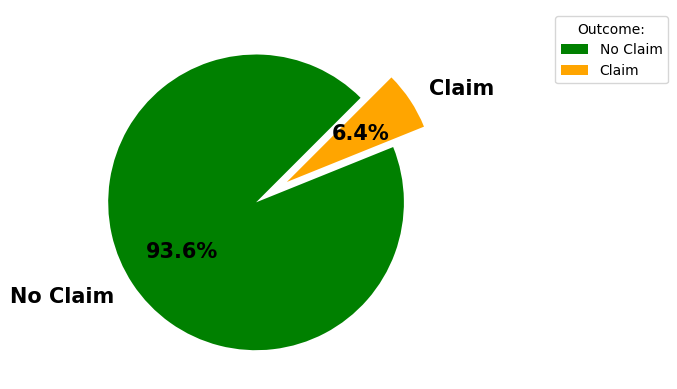

In [36]:
# plotting the is_claim variable in pie chart 

fig = plt.figure(facecolor='white')

ax = fig.add_subplot(1, 1, 1, facecolor='white')

plt.pie(df['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})

plt.legend(title='Outcome:', loc='upper right', bbox_to_anchor=(1.6, 1))

fig.patch.set_facecolor('white')

plt.show()

Next, we will plot histograms to make a few observations.

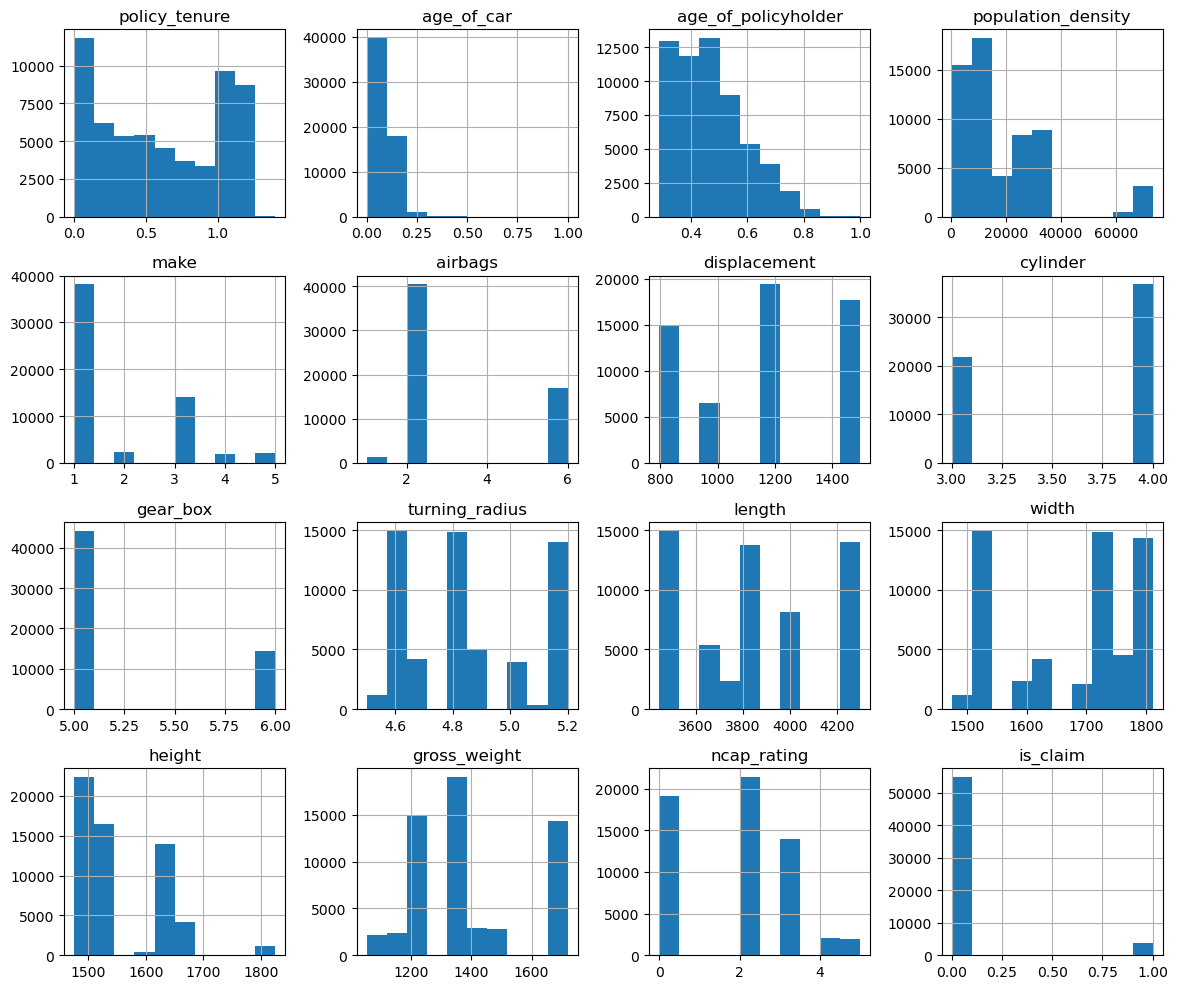

In [37]:
df.hist(figsize=(12, 10))
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

Observations

1. Most people (7000) have had their policy active for 0.1 years.
2. The majority of people opt for insurance immediately when they purchase a car.
3. Most policyholders are 0.3–0.4 years of age.
4. Most people prefer 'make 1' cars, followed by 'make 3, and the least preferred are '2, '4, and '5.
5. The number of airbags in most cars is 5. The number of airbags in most cars is "2" (40k+), while the 2nd most popular 6. choice is '6' (17k approx).
7. The 1' airbag is present in almost 1000 cars, while no car has '3,'4' or '5' airbags.
8. Most cars have a ncap rating of '2' (20k+), followed by a rating of 0' (approximately 19k).
9. Cars with ratings of '4' and '5' are the safest (2.5k each).

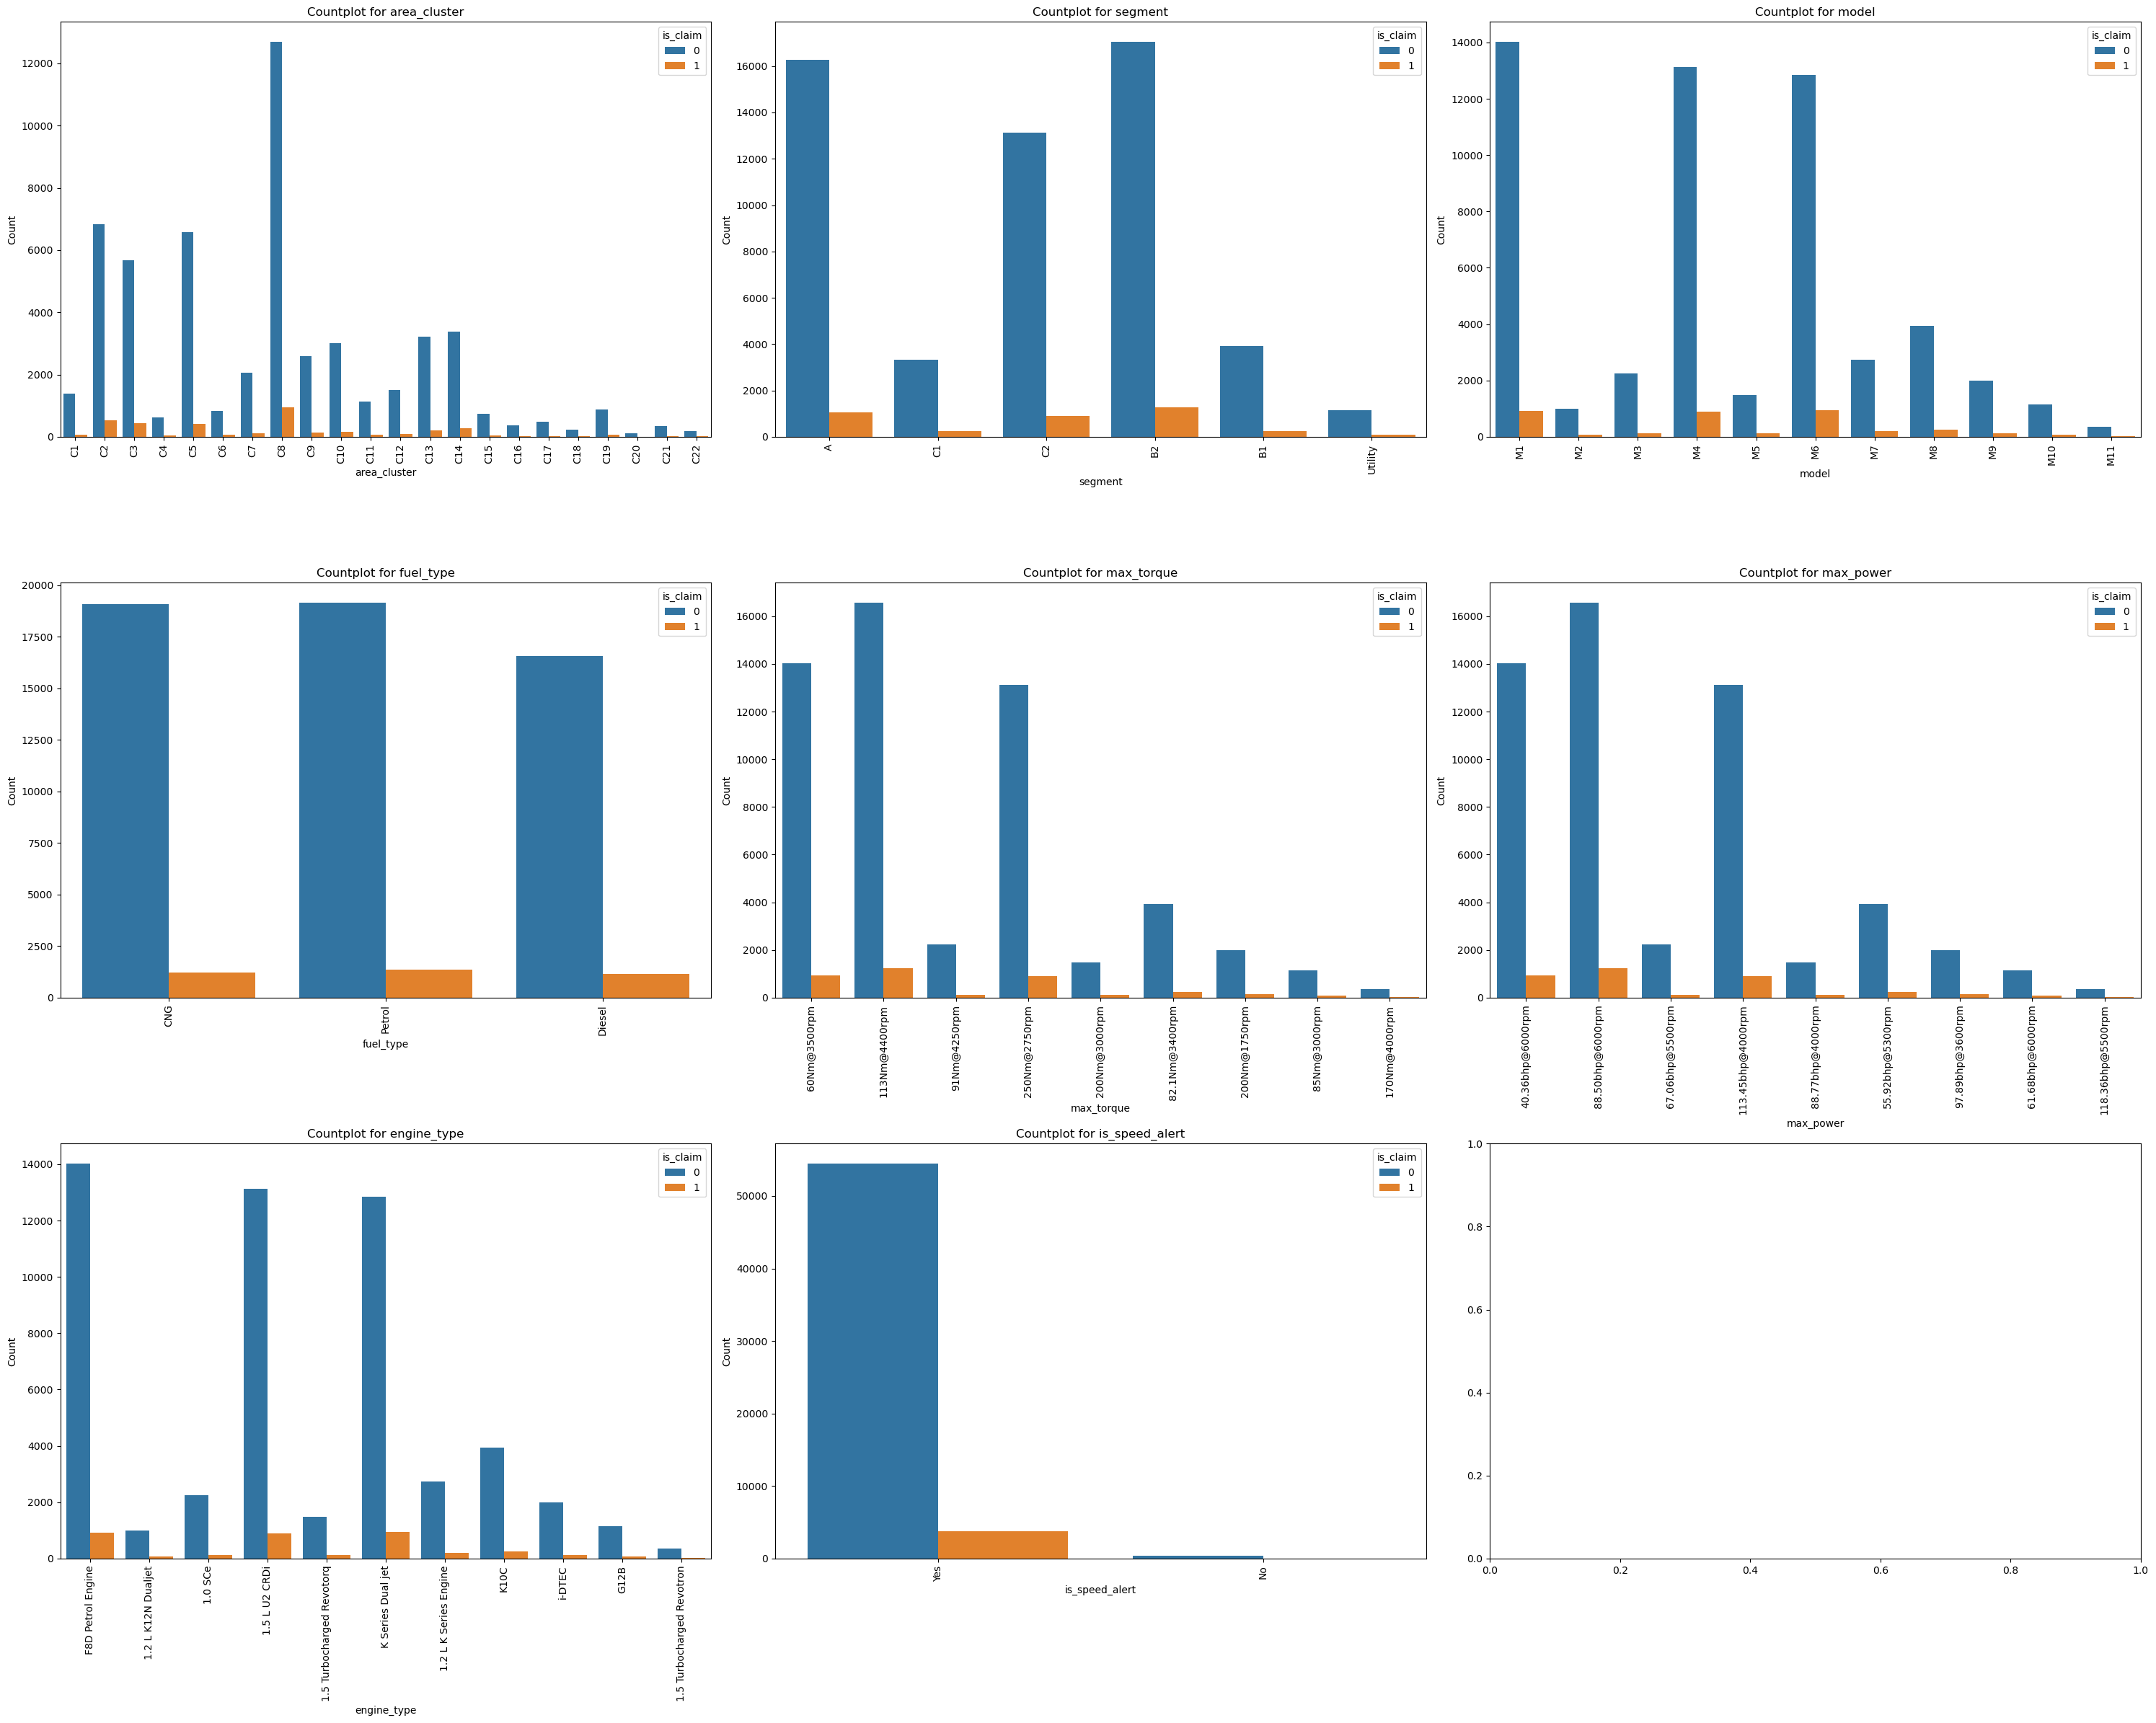

In [45]:
# Create the figure and subplots

fig, axes = plt.subplots(3,3, figsize=(30,24))
axes = axes.flatten()

cols_1=['area_cluster', 'segment', 'model', 'fuel_type', 'max_torque','max_power', 'engine_type', 'is_speed_alert']

for i, column in enumerate(cols_1):
    ax = axes[i]  # Select the current subplot

    # Plot the countplot
    sns.countplot(data=df, x=column, ax=ax, hue='is_claim')
    ax.set_title(f'Countplot for {column}')
    
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels if need
    
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Observations

1. The highest number of claims (about 1000) come from area C8.
2. Owners of models M1, M4, and M6 have the highest claims (about 1000 each).
3. There are zero claims where the speed alert system isn't present in the car.

# 3 Preprocessing and Feature EDA

In [46]:
df['max_torque'].value_counts()

max_torque
113Nm@4400rpm     17796
60Nm@3500rpm      14948
250Nm@2750rpm     14018
82.1Nm@3400rpm     4173
91Nm@4250rpm       2373
200Nm@1750rpm      2114
200Nm@3000rpm      1598
85Nm@3000rpm       1209
170Nm@4000rpm       363
Name: count, dtype: int64

we can extract torque and rpm from the above features to get the new feature 'torque/rpm ratio.

For training dataset

In [47]:
df['torque'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
df['rpm'] = df['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
df['torque'] = pd.to_numeric(df['torque'])
df['rpm'] = pd.to_numeric(df['rpm'])

# Calculate torque to RPM ratio 
df['torque to rpm ratio'] = df['torque'] / df['rpm']

In [48]:
# Deleting redundant columns from training set
df.drop('max_torque', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('torque',axis=1,inplace=True)

In [49]:
df['max_power'].value_counts()

max_power
88.50bhp@6000rpm     17796
40.36bhp@6000rpm     14948
113.45bhp@4000rpm    14018
55.92bhp@5300rpm      4173
67.06bhp@5500rpm      2373
97.89bhp@3600rpm      2114
88.77bhp@4000rpm      1598
61.68bhp@6000rpm      1209
118.36bhp@5500rpm      363
Name: count, dtype: int64

In [50]:
df['power'] = df['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
df['rpm'] = df['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

# Convert the columns to numeric data type
df['power'] = pd.to_numeric(df['power'])
df['rpm'] = pd.to_numeric(df['rpm'])

# Calculate power to RPM ratio
df['power to rpm ratio'] = df['power'] / df['rpm']

In [51]:
df.drop('power', axis=1,inplace=True)
df.drop('rpm',axis=1,inplace=True)
df.drop('max_power',axis=1,inplace=True)

Encoding all the boolean data into numerical values to fit machine learning models

In [52]:
is_cols=[col for col in df.columns if col.startswith("is") and col!="is_claim"]
print(is_cols)

['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [53]:
df = df.replace({ "No" : 0 , "Yes" : 1 })

In [54]:
dataset_num_col = df.select_dtypes(include=['int', 'float']).columns
print(" Data Set Numerical columns:")
print(dataset_num_col.nunique())
print(dataset_num_col)

 Data Set Numerical columns:
34
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'torque to rpm ratio',
       'power to rpm ratio'],
      dtype='object')


In [61]:
dataset_cat_cols = df.select_dtypes(include=['object']).columns
print("Data Set categorical columns:")
print(dataset_cat_cols.nunique())
print(dataset_cat_cols)

Data Set categorical columns:
0
Index([], dtype='object')


Now, we will encode the catagorical columns.

In [62]:
df= pd.get_dummies(df, columns=dataset_cat_cols,drop_first=True)

Due to the highly imbalanced nature of the dataset, it needs to be adjusted to be able to provide valid results. To do so, we have chosen to undersample the ratio of the claim being passed to the claim being rejected at 2:1.

In [66]:
# Separate the majority and minority classes
majority_class = df[df['is_claim_1'] == 0]
minority_class = df[df['is_claim_1'] == 1]

# Undersample the majority class
undersampled_majority = resample(
    majority_class,
    replace=False,  # Set to False for undersampling
    n_samples=len(minority_class) * 2,  # Desired number of records in the majority class
    random_state=42  # Set a random seed for reproducibility
)

# Combine the undersampled majority class with the minority class
df_final = pd.concat([undersampled_majority, minority_class])

Now to check which input features are the least strongly correlated to the target variable 'is_claim', we will plot the correlation heat matrix of the Top 10 least correlated variables available to us.

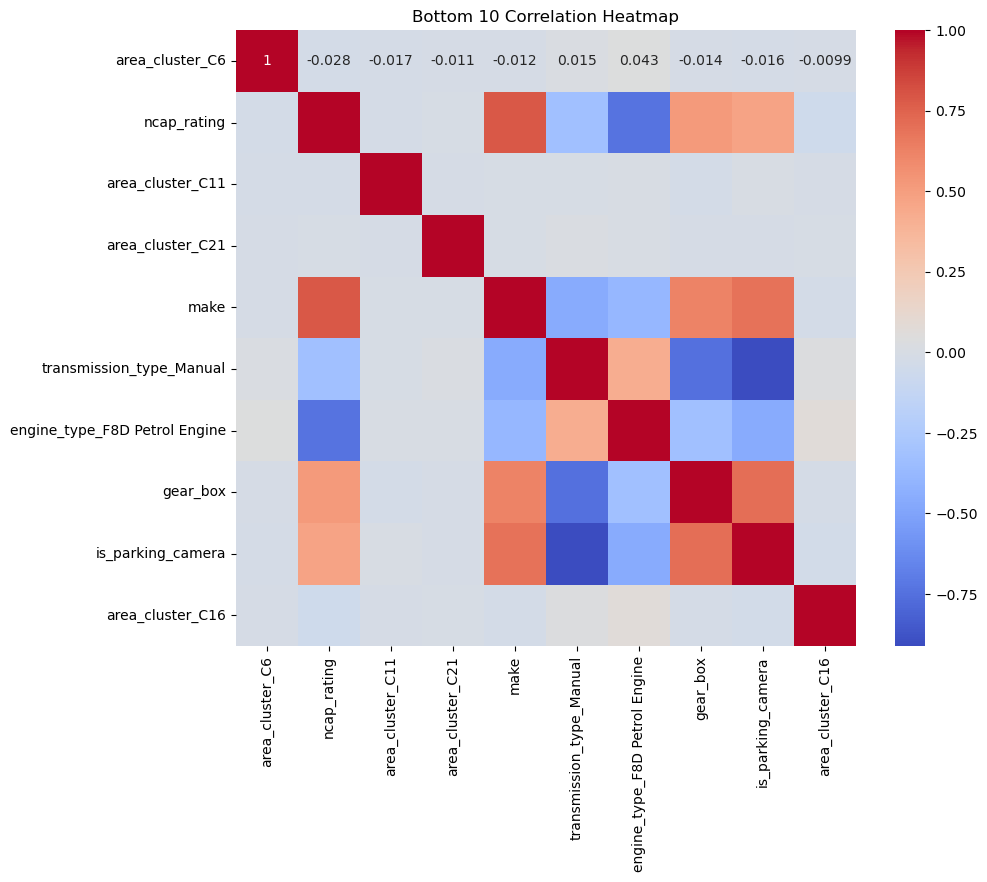

In [74]:
num_bottom_features = 10

correlation_values = df_final.corr()['is_claim_1'].abs().sort_values(ascending=True)[:num_bottom_features]
bottom_features = correlation_values.index

subset_df = df_final[bottom_features]
correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title(f'Bottom {num_bottom_features} Correlation Heatmap')
plt.show()

Upon plotting this map, we can notice that the bottom 3 variables correlated to or affecting the 'is_claim' variable are:

1. gear_box
2. is_parking_camera
3. area_cluster_C16

So our next step will be to drop these bottom 3 variables from our feature vector.

# 4 Splitting the dataset

In [77]:
X = df_final.drop(['gear_box', 'is_parking_camera', 'area_cluster_C16'], axis=1)  # Features
y = df_final['is_claim_1']  # Target variable

we will be splitting the dataset into 80:20 ratio

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
y_train.value_counts()

is_claim_1
False    5987
True     3008
Name: count, dtype: int64

In [80]:
y_test.value_counts()

is_claim_1
False    1509
True      740
Name: count, dtype: int64

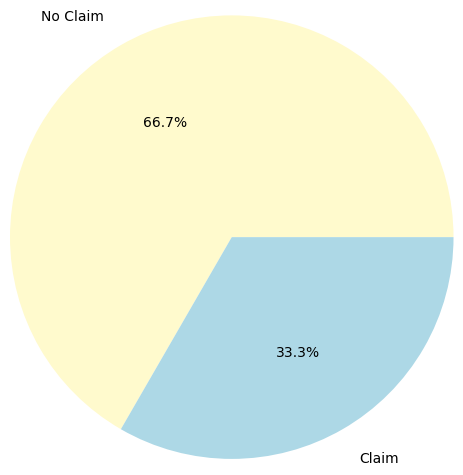

In [81]:
plt.pie(y.value_counts(),labels=['No Claim','Claim'],radius=1.5,colors = ['#FFFACD','#ADD8E6'],
        autopct='%1.1f%%',labeldistance=1.15,startangle =0)

plt.show()

The target class is now balanced with the desired number of claims and no claims.

# 5. Classification model selection and training

The dataset we are using in this project is high-dimensional in nature, containing various complex relationships, so we will be using multiple classification techniques to find our best fit.

#### 1. Logistic Regression

In [83]:
# Create an instance of Logistic Regression
logreg = LogisticRegression()

# Fit the logistic regression model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.670964873277012
Classification Report:
               precision    recall  f1-score   support

       False       0.67      1.00      0.80      1509
        True       0.00      0.00      0.00       740

    accuracy                           0.67      2249
   macro avg       0.34      0.50      0.40      2249
weighted avg       0.45      0.67      0.54      2249



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

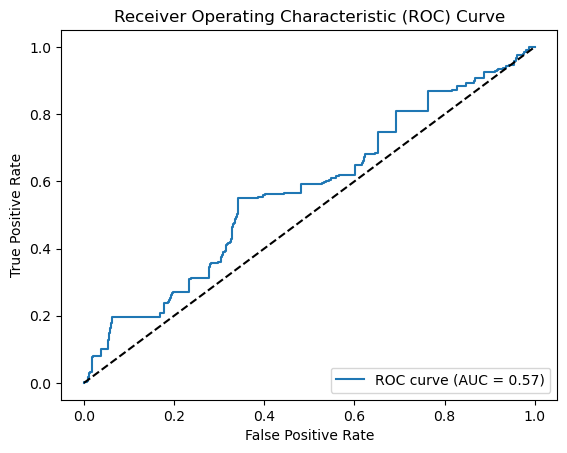

In [87]:
# Get the predicted probabilities for the positive class
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 2 Decision Trees

In [89]:
# Create an instance of DecisionTreeClassifier
tree = DecisionTreeClassifier()

# Fit the decision tree model on the training data
tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = tree.predict(X_test)

In [90]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1509
        True       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249



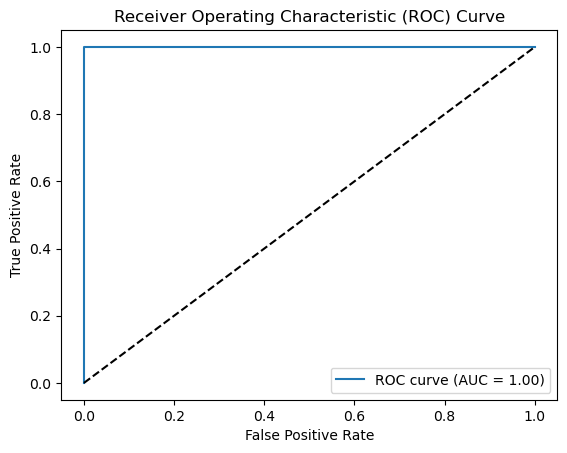

In [91]:
# Get the predicted probabilities for the positive class
y_pred_proba = tree.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 3 Naive Bayes

In [93]:
# Create an instance of Gaussian Naive Bayes classifier
naive_bayes = GaussianNB()

# Fit the Naive Bayes model on the training data
naive_bayes.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = naive_bayes.predict(X_test)

In [94]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9911071587372166
Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      0.99      1509
        True       1.00      0.97      0.99       740

    accuracy                           0.99      2249
   macro avg       0.99      0.99      0.99      2249
weighted avg       0.99      0.99      0.99      2249



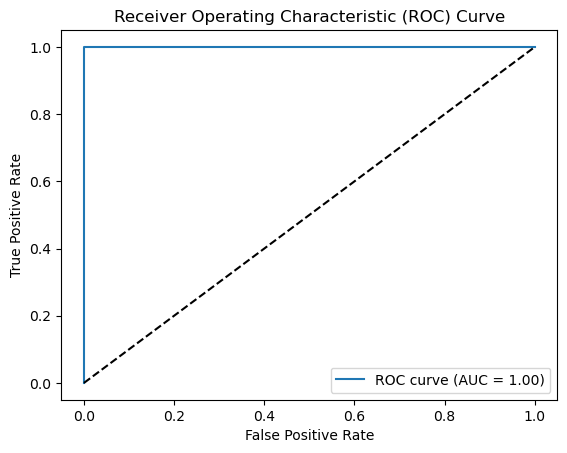

In [95]:
# Get the predicted probabilities for the positive class
y_pred_proba = naive_bayes.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Result

#### 4. Xgboost

In [97]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create an instance of the XGBoost Classifier
xgb_model = XGBClassifier()

# Fit the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1509
        True       1.00      1.00      1.00       740

    accuracy                           1.00      2249
   macro avg       1.00      1.00      1.00      2249
weighted avg       1.00      1.00      1.00      2249



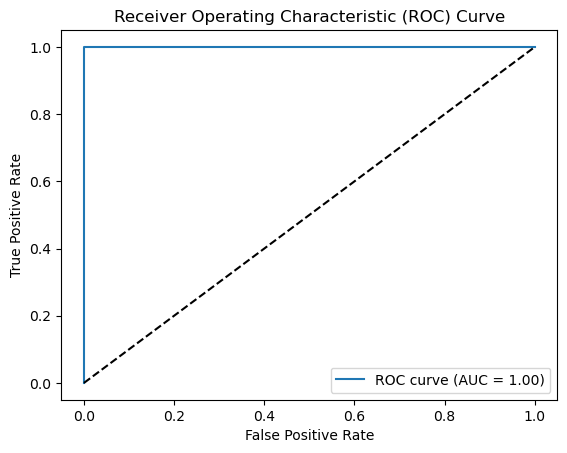

In [99]:
# Get the predicted probabilities for the positive class
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


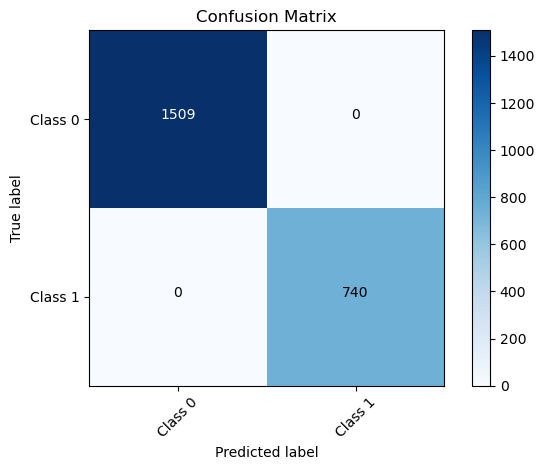

In [100]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(y_test, y_pred, classes=['Class 0', 'Class 1'])
plt.show()

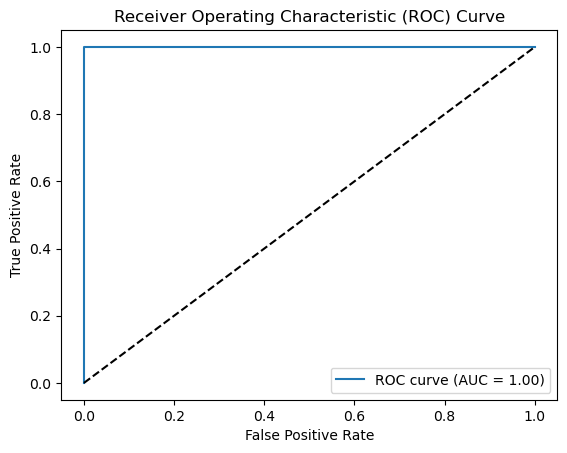

In [102]:
# Get the predicted probabilities for the positive class
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

From the above confusion matrix, we can see that most of the instances of data available to us have been placed in the leading diagonal, which are the true positive and true negative values. This means that all the insurance claims that the model said were passed had actually been passed, and almost all the insurance claims that the model said were not passed had actually not been passed. Only 20 instances were such where the model predicted the claim to pass when actually it had not,  showing almost 100% accuracy.

In [103]:
# Define the models and their respective parameter grids
models = [
    ("Logistic Regression", LogisticRegression(), {}),
    ("Decision Tree", DecisionTreeClassifier(), {}),
    ("Naive Bayes", GaussianNB(), {}),
    ("Xgboost", XGBClassifier(), {})
]

best_model = None
best_accuracy = 0

In [104]:
# Iterate over each model
for name, model, params in models:
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params,
                                       scoring='accuracy', n_iter=3, cv=3, random_state=45)
    random_search.fit(X_train, y_train)
    accuracy = random_search.best_score_

    print(f"Model: {name}")
    print(f"Best Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"\nBest Model based on Accuracy: {best_model}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

Model: Logistic Regression
Best Accuracy: 0.8479121681877059
Model: Decision Tree
Best Accuracy: 1.0
Model: Naive Bayes
Best Accuracy: 0.988994293035044
Model: Xgboost
Best Accuracy: 1.0

Best Model based on Accuracy: DecisionTreeClassifier()
